#### [Formação do Dataframe](#dataframe)
#### [Train Test Split](#split)
#### [Vetorização](#vetorizacao)
#### [Rede Neural](#rede)

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### Arquivos

In [2]:
listdir()

['.git',
 '.ipynb_checkpoints',
 'labels.txt',
 'mini_projeto_sentiment_analysis.ipynb',
 'model.pt',
 'reviews.txt',
 'Sentiment Analysis Intro.ipynb',
 'sentiment_network.png',
 'sentiment_network_2.png',
 'sentiment_network_pos.png']

### Formação do Dataframe <a id="dataframe">

In [3]:
df = pd.read_csv('reviews.txt', header=None, names=['text'])

In [4]:
pd.set_option('display.max_colwidth',150)
df.head()

,text
0,bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my years in the teach...
1,story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orche...
2,homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once co...
3,airport starts as a brand new luxury plane is loaded up with valuable paintings such belonging to rich businessman philip stevens james st...
4,brilliant over acting by lesley ann warren . best dramatic hobo lady i have ever seen and love scenes in clothes warehouse are second to none . ...


In [5]:
df_rev = pd.read_csv('labels.txt', header=None, names=['labels'])
df_rev.head()

,labels
0,positive
1,negative
2,positive
3,negative
4,positive


In [6]:
df['labels'] = df_rev.labels
df.head()

,text,labels
0,bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my years in the teach...,positive
1,story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orche...,negative
2,homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once co...,positive
3,airport starts as a brand new luxury plane is loaded up with valuable paintings such belonging to rich businessman philip stevens james st...,negative
4,brilliant over acting by lesley ann warren . best dramatic hobo lady i have ever seen and love scenes in clothes warehouse are second to none . ...,positive


In [7]:
df.labels = df.labels.apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,text,labels
0,bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my years in the teach...,1
1,story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orche...,0
2,homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once co...,1
3,airport starts as a brand new luxury plane is loaded up with valuable paintings such belonging to rich businessman philip stevens james st...,0
4,brilliant over acting by lesley ann warren . best dramatic hobo lady i have ever seen and love scenes in clothes warehouse are second to none . ...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
text      25000 non-null object
labels    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


In [9]:
df.labels.value_counts()

1    12500
0    12500
Name: labels, dtype: int64

In [10]:
df.labels.iloc[-4000:-1000].value_counts()

1    1500
0    1500
Name: labels, dtype: int64

### Vetorização <a id="vetorizacao">

In [11]:
def test_df_max(max_df=[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]):
    for m in max_df:
        vect = TfidfVectorizer(max_df = m)
        print(f'shape test for max {m}: {vect.fit_transform(df.text).shape}')

In [12]:
def test_df_min(min_df=[1, 10, 100, 1000, 10000]):
    for m in min_df:
        vect = TfidfVectorizer(min_df = m)
        print(f'shape test for min {m}: {vect.fit_transform(df.text).shape}')

### Tamanhos da Saída para Diferentes min, max doc. freq
##### shape test for max 1.0: (25000, 74046)
##### shape test for max 0.9: (25000, 74041)
##### shape test for max 0.8: (25000, 74037)
##### shape test for max 0.7: (25000, 74035)
##### shape test for max 0.6: (25000, 74030)
##### shape test for max 0.5: (25000, 74020)
##### shape test for max 0.4: (25000, 74004)
##### shape test for max 0.3: (25000, 73985)
##### shape test for max 0.2: (25000, 73940)
##### shape test for max 0.1: (25000, 73832)
##### shape test for max 0.05: (25000, 73618)
##### _
##### shape test for min 1: (25000, 74046)
##### shape test for min 10: (25000, 18278)
##### shape test for min 100: (25000, 3793)
##### shape test for min 1000: (25000, 522)
##### shape test for min 10000: (25000, 42)


In [13]:
vect = TfidfVectorizer(min_df=50, max_df=0.5, ngram_range=(1,3))

In [14]:
vect.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.5,
 'max_features': None,
 'min_df': 50,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [15]:
x = vect.fit_transform(df.text)

In [16]:
len(vect.get_feature_names())

21726

In [17]:
x.shape

(25000, 21726)

In [18]:
vect.get_feature_names()[:10]

['abandon',
 'abandoned',
 'abc',
 'abilities',
 'ability',
 'ability to',
 'able',
 'able to',
 'able to get',
 'able to see']

### Train Test Validation Split <a id="split">

In [19]:
type(x.todense())

numpy.matrix

In [20]:
x_tensor = torch.tensor(x.todense(), requires_grad=False)

In [21]:
x_tensor.shape[1]

21726

In [22]:
x_train = x_tensor[:-4000]
x_valid = x_tensor[-4000:-1000]
x_test = x_tensor[-1000:]

In [23]:
x_train.shape

torch.Size([21000, 21726])

In [24]:
x_valid.shape

torch.Size([3000, 21726])

In [25]:
x_test.shape

torch.Size([1000, 21726])

In [26]:
y_train = torch.tensor(df.labels.iloc[:-4000].values, requires_grad=False)
y_valid = torch.tensor(df.labels.iloc[-4000:-1000].values, requires_grad=False)
y_test = torch.tensor(df.labels.iloc[-1000:].values, requires_grad=False)

In [27]:
y_train.shape

torch.Size([21000])

In [28]:
y_valid.shape

torch.Size([3000])

In [29]:
y_test.shape

torch.Size([1000])

### Rede Neural <a id="rede">

#### Definição

In [30]:
class Model(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        relu = nn.ReLU()
        x = relu(x)
        x = self.linear2(x)
        sig = nn.Sigmoid()
        x = sig(x)
        return x

#### Treino

In [70]:
# B is batch size D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
B, D_in, H, D_out = 1, x_tensor.shape[1], 2048, 1


# Construct our model by instantiating the class defined above
model = Model(D_in, H, D_out)

model.float()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_list = []

loss_list_valid = []

tolerance = 10

best_valid_loss = np.inf

last_model = 0

test = 0

for t in range(100):
    model.train()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_train.float())

    # Compute and print loss
    loss = criterion(y_pred.float(), y_train.view(y_train.shape[0],1).float())
    
    #print(f'pred: \n{y_pred}')
    #print(f'true: \n{y_train.view(y_train.shape[0],1)}')
    
    
    
    loss_list.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    
    y_pred_valid = model(x_valid.float())
    
    loss_valid = criterion(y_pred_valid.float(), y_valid.view(y_valid.shape[0],1).float())
    
    loss_list_valid.append(loss_valid.item())
    
    # Early stopping
    
        
    if loss_valid.item() >= best_valid_loss:
        test += 1
        
        if test == tolerance:
            print(f"Tolerância ({tolerance}) atingida na época {t}")
            print(f"loss: {loss.item()}- valid loss: {loss_valid.item()}")
            break
    else:
        test = 0
        best_valid_loss = loss_valid.item()
        torch.save(model.state_dict(), "model.pt")
        last_model = t
    
    print(f"t: {t}, loss: {loss.item()}, loss_valid: {loss_valid.item()}")
    
    

t: 0, loss: 0.6931325793266296, loss_valid: 0.5613089799880981
t: 1, loss: 0.5463476777076721, loss_valid: 0.391254186630249
t: 2, loss: 0.3506111800670624, loss_valid: 0.3086736798286438
t: 3, loss: 0.23593385517597198, loss_valid: 0.2817278206348419
t: 4, loss: 0.17538222670555115, loss_valid: 0.5038548111915588
t: 5, loss: 0.2731073498725891, loss_valid: 0.46863502264022827
t: 6, loss: 0.2745819091796875, loss_valid: 0.3421013653278351
t: 7, loss: 0.14858348667621613, loss_valid: 0.37425774335861206
t: 8, loss: 0.12306645512580872, loss_valid: 0.486795574426651
t: 9, loss: 0.16690970957279205, loss_valid: 0.33351945877075195
t: 10, loss: 0.06976021081209183, loss_valid: 0.3505297303199768
t: 11, loss: 0.08036580681800842, loss_valid: 0.40740329027175903
t: 12, loss: 0.10198088735342026, loss_valid: 0.3533080518245697
Tolerância (10) atingida na época 13
loss: 0.05014693737030029- valid loss: 0.367693156003952


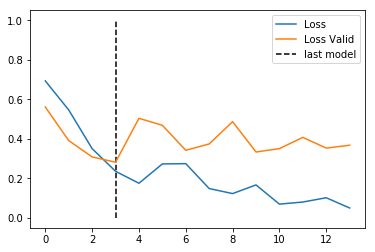

In [77]:
#fig, ax = plt.subplots(2,1)
plt.plot(range(len(loss_list)), loss_list, label="Loss")
plt.plot(range(len(loss_list_valid)), loss_list_valid, label="Loss Valid")
plt.vlines(last_model, 0.0, 1.0, label = "last model", linestyles='dashed')
plt.legend()
plt.show()

### Testando o Modelo

In [72]:
model = Model(D_in, H, D_out)
model.load_state_dict(torch.load('model.pt'))
model.eval()

Model(
  (linear1): Linear(in_features=21726, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1, bias=True)
)

In [73]:
pred = model(x_test.float())

In [74]:
print('TN-FP\nFN-TP')
confusion_matrix(y_test, pred.round().detach().numpy())  

TN-FP
FN-TP


array([[416,  84],
       [ 64, 436]], dtype=int64)

In [75]:
accuracy_score(y_test, pred.round().detach().numpy())  

0.852

In [76]:
print(classification_report(y_test, pred.round().detach().numpy(),
                            target_names= ['negativo', 'positivo']))

              precision    recall  f1-score   support

    negativo       0.87      0.83      0.85       500
    positivo       0.84      0.87      0.85       500

   micro avg       0.85      0.85      0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

